## **1. Matériel : vérifier que le GPU est bien sélectionné**

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat May 18 22:33:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              28W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## **2. Importation des librairies**

In [2]:
import sys,os
import torch, torchvision
#import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torch.nn as nn
from torchsummary import summary

from torch import Tensor
from functools import partial

from torchvision.transforms._presets import ImageClassification
import torchvision.models as models
from torchvision.models import ResNet50_Weights
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [3]:
! pip install torch_pruning

## **3. Importation des données**

In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
folder='/content/drive/MyDrive/Workshop/' #@param ['/content/drive/MyDrive/Workshop/','/content/drive/MyDrive/IA/UMONS/Workshop/']

image_classification_path = f'{folder}2. Image classification'

training_path=   image_classification_path + '/' + 'data'
testing_path = image_classification_path + '/' + 'test'
sys.path.append(image_classification_path)
os.chdir(image_classification_path)


Mounted at /content/drive


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **4. Paramètres**

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [7]:
batch_size="32" #@param [16,32]
batch_size = int(batch_size)
validation_split = 0.1
seed = 50 #@param

## **5. Visualiser une image**

In [8]:
transformView = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    #transforms.RandomRotation(15),       # Randomly rotate the images by +/- 15 degrees
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

datasetView = datasets.ImageFolder(training_path, transformView)
dataloaderView = torch.utils.data.DataLoader(datasetView, batch_size=batch_size, shuffle=True)

test_dataset = datasets.ImageFolder(root=testing_path, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
from collections import Counter

# Count the number of instances per class
class_counts = Counter(datasetView.targets)
total_images = len(datasetView)

# Calculate the proportion of each class
class_proportions = {datasetView.classes[i]: count / total_images for i, count in class_counts.items()}

# Print the class proportions
print("Class Proportions:")
for class_name, proportion in class_proportions.items():
    print(f"{class_name}: {proportion:.2f}")

Class Proportions:
fire: 0.38
no_fire: 0.34
start_fire: 0.28


In [10]:
from torch.utils.data import random_split

total_size = len(datasetView)
train_size = int(total_size * (1 - validation_split))
validation_size = total_size - train_size

torch.manual_seed(seed)
train_dataset, validation_dataset = random_split(datasetView, [train_size, validation_size])

# Create DataLoaders for each dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

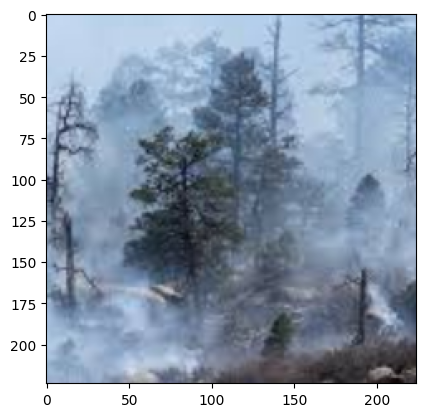

In [11]:
images,labels = next(iter(dataloaderView))
imshow(images[0].permute(1, 2, 0))

## models

In [17]:
import torch
import torch.nn as nn
from torchvision import models

def create_resnet(num_classes):
    # Load a pre-trained ResNet18 model
    model = models.resnet152(pretrained=True)

    # Freeze all the parameters in the model
    for param in model.parameters():
        param.requires_grad = False

    # Replace the last fully connected layer with a new one with `num_classes` outputs
    num_ftrs = model.fc.in_features
    # Create a new classifier with additional layers
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 128),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(32, num_classes),  # Use num_classes here to make it flexible
        nn.Softmax(dim=1)
    )

    return model.cuda()

def create_squeezenet(num_classes):
    # Load a pre-trained SqueezeNet model
    model = models.squeezenet1_1(pretrained=True)

    # Freeze all the parameters in the model
    for param in model.parameters():
        param.requires_grad = False

    # SqueezeNet uses a final Conv2d layer as the classifier
    # The final classifier is a Conv2d layer in the 'classifier' module
    final_conv = nn.Conv2d(512, num_classes, kernel_size=(1,1))

    # Replace the classifier module
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        final_conv,
        nn.ReLU(inplace=True),
        nn.AdaptiveAvgPool2d((1, 1))
    )

    return model.cuda()

def create_mobilenet(num_classes):
    # Load a pre-trained MobileNetV2 model
    model = models.mobilenet_v2(pretrained=True)

    # Freeze all the parameters in the model
    for param in model.parameters():
        param.requires_grad = False

    # MobileNetV2 uses 'classifier' instead of 'fc' used by ResNet
    # The last layer of MobileNetV2's classifier is a Linear layer with 1280 input features
    num_ftrs = model.classifier[1].in_features

    # Replace the classifier with a new one
    model.classifier = nn.Sequential(
        nn.Linear(num_ftrs, 128),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(32, num_classes),
        nn.Softmax(dim=1)  # Softmax for classification
    )

    return model.cuda()

model = create_resnet(3)

In [13]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # No need to track gradients for evaluation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total * 100
    return avg_loss, accuracy

In [14]:
criterion = nn.CrossEntropyLoss()
model_name = "wide_resnet"
if model_name == "wide_resnet":
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
else:
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)  # Optimize only the last layer

## Train

In [15]:
import torch.nn.functional as F
import torch
import torch_pruning as tp
import os
import copy
import random
import numpy as np
import torch
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm
from functools import partial

@torch.no_grad()
def evaluate(
    model: nn.Module,
    dataloader: DataLoader,
    verbose=True,
) -> float:
    model.eval()

    num_samples = 0
    num_correct = 0
    loss = 0

    for inputs, targets in tqdm(dataloader, desc="eval", leave=False, disable=not verbose):
        # Move the data from CPU to GPU
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Inference
        outputs = model(inputs)
        # Calculate loss
        loss += F.cross_entropy(outputs, targets, reduction="sum")
        # Convert logits to class indices
        outputs = outputs.argmax(dim=1)
        # Update metrics
        num_samples += targets.size(0)
        num_correct += (outputs == targets).sum()
    return (num_correct / num_samples * 100).item(), (loss / num_samples).item()

# training loop
def train(
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    epochs: int,
    lr: int,
    # for pruning
    weight_decay=5e-4,
    pruner=None,
    callbacks=None,
    save=None,
    save_only_state_dict=False,
) -> None:

    optimizer = torch.optim.SGD(model.parameters(
    ), lr=lr, momentum=0.9, weight_decay=weight_decay if pruner is None else 0)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,80,100], gamma=0.1)
    criterion = nn.CrossEntropyLoss()
    best_acc = -1
    best_checkpoint = dict()


    for epoch in range(epochs):
        model.train()
        for inputs, targets in tqdm(train_loader, leave=False):
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Reset the gradients (from the last iteration)
            optimizer.zero_grad()

            # Forward inference
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward propagation
            loss.backward()

            # Pruner regularize for sparsity learning
            if pruner is not None:
                pruner.regularize(model)

            # Update optimizer
            optimizer.step()

            if callbacks is not None:
                for callback in callbacks:
                    callback()

        acc, val_loss = evaluate(model, test_loader)
        print(
            f'Epoch {epoch + 1}/{epochs} | Val acc: {acc:.2f} | Val loss: {val_loss:.4f} | LR: {optimizer.param_groups[0]["lr"]:.6f}')

        if best_acc < acc:
            best_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
            best_acc = acc
        # Update LR scheduler
        scheduler.step()
    model.load_state_dict(best_checkpoint['state_dict'])
    if save:
        # on veut sauvegarder le meilleur modèle
        path = os.path.join(os.getcwd(), "results", save)
        os.makedirs(os.path.dirname(path), exist_ok=True)
        if save_only_state_dict:
            torch.save(model.state_dict(), path)
        else:
            torch.save(model, path)
    print(f'Best val acc: {best_acc:.2f}')



# Pruner
# définir le nbre de classses => évite de pruner la dernière couche
def get_pruner(model, example_input):
    sparsity_learning = False
    if method == "random":
        imp = tp.importance.RandomImportance()
        pruner_entry = partial(tp.pruner.MagnitudePruner, global_pruning=global_pruning)
    elif method == "l1":
        imp = tp.importance.MagnitudeImportance(p=1)
        pruner_entry = partial(tp.pruner.MagnitudePruner, global_pruning=global_pruning)
    elif method == "lamp":
        imp = tp.importance.LAMPImportance(p=2)
        pruner_entry = partial(tp.pruner.BNScalePruner, global_pruning=global_pruning)
    elif method == "slim":
        sparsity_learning = True
        imp = tp.importance.BNScaleImportance()
        pruner_entry = partial(tp.pruner.BNScalePruner, reg=1e-5, global_pruning=global_pruning)
    elif method == "group_norm":
        imp = tp.importance.GroupNormImportance(p=2)
        pruner_entry = partial(tp.pruner.GroupNormPruner, global_pruning=global_pruning)
    elif method == "group_sl":
        sparsity_learning = True
        imp = tp.importance.GroupNormImportance(p=2)
        pruner_entry = partial(tp.pruner.GroupNormPruner, reg=1e-5, global_pruning=global_pruning)
    else:
        raise NotImplementedError

    unwrapped_parameters = []
    ignored_layers = []
    ch_sparsity_dict = {}
    # ignore output layers
    for m in model.modules():
        if isinstance(m, torch.nn.Linear) and m.out_features == num_classes:
            ignored_layers.append(m)
        elif isinstance(m, torch.nn.modules.conv._ConvNd) and m.out_channels == num_classes:
            ignored_layers.append(m)


    # Here we fix iterative_steps=200 to prune the model progressively with small steps
    # until the required speed up is achieved.
    pruner = pruner_entry(
        model,
        example_input,
        importance=imp,
        iterative_steps=iterative_steps,
        ch_sparsity=1,
        ch_sparsity_dict=ch_sparsity_dict,
        ignored_layers=ignored_layers,
        unwrapped_parameters=unwrapped_parameters,
    )
    return pruner

# pruning jusqu'à atteindre le speed up voulu
def progressive_pruning_speedup(pruner, model, speed_up, example_inputs):
    model.eval()
    base_ops, _ = tp.utils.count_ops_and_params(
        model, example_inputs=example_inputs)
    current_speed_up = 1
    while current_speed_up < speed_up:
        pruner.step(interactive=False)
        pruned_ops, _ = tp.utils.count_ops_and_params(
            model, example_inputs=example_inputs)
        current_speed_up = float(base_ops) / pruned_ops
        # print(current_speed_up)
        if pruner.current_step == pruner.iterative_steps:
            break
    return current_speed_up


# pruning jusqu'à atteindre le ratio de compression voulu
def progressive_pruning_compression_ratio(pruner, model, compression_ratio, example_inputs):
    # compression ratio défini par taille initiale / taille finale
    model.eval()
    _, base_params = tp.utils.count_ops_and_params(
        model, example_inputs=example_inputs)
    current_compression_ratio = 1
    while current_compression_ratio < compression_ratio:
        pruner.step(interactive=False)
        _, pruned_params = tp.utils.count_ops_and_params(
            model, example_inputs=example_inputs)
        current_compression_ratio = float(base_params) / pruned_params
        if pruner.current_step == pruner.iterative_steps:
            break
        # print(current_compression_ratio)
    return current_compression_ratio



def main():
    # Avant pruning
    example_input = torch.rand(1, 3, 224, 224).to(device)
    start_macs, start_params = tp.utils.count_ops_and_params(model, example_input)
    print('----- Avant pruning -----')
    print(f'Nombre de MACs = {start_macs/1e6:.3f} M')
    print(f'Nombre de paramètres = {start_params/1e6:.3f} M')
    print('')

    pruner = get_pruner(model, example_input)
    print(f'Pruning method = {method}')

    # pruning using compression ratio as objective
    progressive_pruning_compression_ratio(pruner, model, compression_ratio, example_input)

    # pruning using speed up ratio as objective (Number of MACs)
    #progressive_pruning_speedup(pruner, model, speed_up, example_input)

    pruned_macs, pruned_params = tp.utils.count_ops_and_params(model, example_input)
    print('----- Après pruning -----')
    print(f'Nombre de MACs = {pruned_macs/1e6:.3f} M')
    print(f'Nombre de paramètres = {pruned_params/1e6:.3f} M')
    print('')

    # Results
    print('----- Results before fine tuning -----')
    print(f'Params: {start_params/1e6:.2f} M => {pruned_params/1e6:.2f} M')
    print(f'MACs: {start_macs/1e6:.2f} M => {pruned_macs/1e6:.2f} M')
    print('')

## train2

In [18]:
batch_size = 512
epochs = 100
lr = 0.01
random_seed = 42

# pruning parameters
method = "l1" # choices "random", "l1", "lamp", "slim", "group_norm", "group_sl"
speed_up = 2 # speed up ratio based on MACs
compression_ratio = 3 # compression ratio based on model size
global_pruning = False # if True: global pruning else: local
iterative_steps = 400 # pruning steps

num_classes = 3 # to avoid pruning last layer

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)



main()


train(
    model = model,
    train_loader = train_loader,
    test_loader = test_loader,
    epochs = 20,
    lr = 0.01,
    weight_decay=5e-4,
    pruner=None,
    callbacks=None,
    save=None,
    save_only_state_dict=False,
)

----- Avant pruning -----
Nombre de MACs = 11578.906 M
Nombre de paramètres = 58.410 M

Pruning method = l1


/usr/local/lib/python3.10/dist-packages/torch_pruning/pruner/algorithms/metapruner.py:87: UserWarning: ch_sparsity is deprecated in v1.3.0. Please use pruning_ratio.
  warnings.warn("ch_sparsity is deprecated in v1.3.0. Please use pruning_ratio.")
/usr/local/lib/python3.10/dist-packages/torch_pruning/pruner/algorithms/metapruner.py:90: UserWarning: ch_sparsity_dict is deprecated in v1.3.0. Please use pruning_ratio_dict instead.
  warnings.warn("ch_sparsity_dict is deprecated in v1.3.0. Please use pruning_ratio_dict instead.")


----- Après pruning -----
Nombre de MACs = 11578.641 M
Nombre de paramètres = 58.146 M

----- Results before fine tuning -----
Params: 58.41 M => 58.15 M
MACs: 11578.91 M => 11578.64 M



  0%|          | 0/61 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
test_loss, test_accuracy = evaluate_model(model, train_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

In [ ]:

torch.save(model, 'sq_prune_20_rand_local_400_sz2.pth')